# **base.py**

In [ ]:
%%writefile base.py
class Action(object):
    """
    Base class to be implemented by classes representing actions.
    """
    pass

class Perception(object):
    """
    Base class to be implemented by classes representing the totality of an agent's perceptions at a point in time.
    """
    pass


class Agent(object):
    """
    Base class to be implemented by agent implementations. A reactive agent is only defined by its Agent @ to
    perceptions.
    """

    def response(self, perceptions):
        """
        Computes the response of the agent to the perceptions. The perceptions are offered by the environment and the
        action is executed by the environment.

        :param perceptions: the perceptions that are given by the environment to the agent.
        :return: an {@link Action} to be executed by the agent on the environment.
        """
        raise NotImplementedError("Missing a response")

    def __str__(self):
        """
        :return: override to return a 1-character string that encodes the agent name
        """
        return "A"


class AgentData(object):
    """
    The class contains data that characterizes the external state of an agent, from the point of view of the
    environment. For instance, the agent's position.
    """
    def __init__(self, linked_agent):
        """
        :param linked_agent: the internal implementation of the agent about which this
        instance contains environment data.
        """
        self.linked_agent = linked_agent


    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.linked_agent == other.linked_agent
        else:
            return False


class Environment(object):
    """
    Base class to be implemented by environment implementations.
    """

    def goals_completed(self):
        """
        :return: return True if the goals of all the agents have been completed
        """
        raise NotImplementedError("Method not implemented")


    def add_agent(self, agent_data):
        """
        Adds an agent to the environment. The environment places the agent in it, in the specified state.
        :param agent_data: all the data the environment needs about an agent, containing extrinsic state and a
        reference to the agent's implementation.
        """
        raise NotImplementedError("Method not implemented")

    def step(self):
        """
        When the method is invoked, all agents should receive a perception of the environment and decide on an
        action to perform.
        """
        raise NotImplementedError("Method not implemented")

    def __str__(self):
        raise NotImplementedError("Method not implemented")

# **communication.py**

In [ ]:
%%writefile communication.py
from base import Action
from typing import List
from hunting import WildLifeAgent

class AgentMessage(object):

    def __init__(self, sender_id, destination_id, content):
        self.sender_id = sender_id
        self.destination_id = destination_id
        self.content = content

    @staticmethod
    def filter_messages_for(all_messages: List['AgentMessage'], agent: WildLifeAgent):
        """
        helper method to filter from a set of messages only those for a specified agent.
        :param all_messages: the messages to filter.
        :param agent: the destination agent
        :return: messages for the specified destination
        """
        return [msg for msg in all_messages if msg.destination_id == agent.id]


class SocialAction(Action):

    def __init__(self, physical_action):
        """
        Initialize a social action
        :param physical_action: the physical action the agent wants to perform
        """
        self.action = physical_action

        ## the set of outgoing messages, initially empty
        self.outgoing_messages = []


    def add_outgoing_message(self, sender_id, destination_id, content):
        self.outgoing_messages.append(AgentMessage(sender_id, destination_id, content))




# **gridworld.py**

In [ ]:
%%writefile gridworld.py
from base import *
from representation import *
import random
from copy import deepcopy

class GridAgentData(AgentData):
    def __init__(self, linked_agent, grid_position, current_orientation):
        """
        :param linked_agent: the agent
        :param grid_position: the position on the grid
        :param current_orientation: the orientation on the grid
        """
        super(GridAgentData, self).__init__(linked_agent)

        self.grid_position = grid_position
        self.current_orientation = current_orientation

        """
        The number of points gathered by the agent
        """
        self.points = 0


    def add_points(self, delta):
        """
        :param delta: number of points to add; may be negative
        """
        self.points += delta


class NearbyAgent(object):
    """
    Structure storing information about a nearby agent.
    """

    def __init__(self, relative_orientation, is_cognitive, agent_points):
        """
        Creates a new structure indicating information about a nearby agent.
        :param relative_orientation: The GridRelativeOrientation orientation relative to `this' agent
        :param is_cognitive: is the neighbour agent cognitive?
        :param agent_points: the points gathered by the neighbour agent
        """
        self.relative_orientation = relative_orientation
        self.is_cognitive = is_cognitive
        self.agent_points = agent_points





class AbstractGridEnvironment(Environment):

    def __init__(self):
        super(AbstractGridEnvironment, self).__init__()


        """ A `GridPosition' record of all positions on the map, such as to provide reference """
        self._grid_positions = []

        """ Set of junk tile `GridPosition' positions """
        self._jtiles = []

        """ Set of wall tile `GridPosition' positions """
        self._xtiles = []

        """ Min and max values for the corners of the grid environment """
        self._x0 = 0
        self._x1 = 0
        self._y0 = 0
        self._y1 = 0

        """ Width and height of grid cells for display purposes """
        self._cellW = 2
        self._cellH = 2

        """ Set of `GridAgentData' agents populating the environment """
        self._agents = []


    def goals_completed(self):
        return not self._jtiles


    def add_agent(self, agent_data):
        self._agents.append(agent_data)


    def initialize(self, w, h, nr_jtiles, nr_xtiles, rand_seed = None):
        """
        Initializes the environment with the provided width, height and number of J- and X-tiles.
        :param w: width
        :param h: height
        :param nr_jtiles: number of junk tiles
        :param nr_xtiles: number of x tiles
        :param rand_seed: random number generator seed used in generation process, can be None
        """
        for i in range(0, w + 2):
            for j in range(0, h + 2):
                self._grid_positions.append(GridPosition(i, j))

        self._x0 = 0
        self._x1 = w + 1

        self._y0 = 0
        self._y1 = h + 1


        for i in range(0, w + 2):
            self._xtiles.append(GridPosition(i, 0))
            self._xtiles.append((GridPosition(i, self._y1)))

        for j in range(0, h + 2):
            self._xtiles.append(GridPosition(0, j))
            self._xtiles.append((GridPosition(self._x1, j)))

        ## generate rest of X tiles
        attempts = 10 * nr_xtiles * nr_xtiles
        generated = 0

        if rand_seed:
            random.seed(rand_seed)

        while attempts > 0 and generated < nr_xtiles:
            x = random.randint(1, w)
            y = random.randint(1, h)

            pos = GridPosition(x, y)
            ok = True

            for grid_pos in self._xtiles:
                if pos.get_distance_to(grid_pos) <= 2:
                    ok = False

            if ok:
                generated += 1
                self._xtiles.append(pos)

            attempts -= 1

        if generated < nr_xtiles:
            print("Failed to generate all required X-tiles. Wanted: %i, generated: %i" % (nr_xtiles, generated))


        ## generate all J tiles
        attempts = 10 * nr_jtiles * nr_jtiles
        generated = 0

        while attempts > 0 and generated < nr_jtiles:
            x = random.randint(1, w)
            y = random.randint(1, h)

            pos = GridPosition(x, y)

            if not pos in self._jtiles and not pos in self._xtiles:
                generated += 1
                self._jtiles.append(pos)

            attempts -= 1

        if generated < nr_jtiles:
            print("Failed to generate all required J-tiles. Wanted: %i, generated: %i" % (nr_jtiles, generated))



    def clean_tile(self, grid_position):
        """
        Removes a position from the list of dirty tiles.
        :param grid_position: the J tile to remove
        """
        if not grid_position in self._jtiles:
            raise ValueError("GridPosition was not dirty")

        self._jtiles.remove(grid_position)


    def _get_positions(self):
        return deepcopy(self._grid_positions)

    def _get_x_tiles(self):
        return deepcopy(self._xtiles)

    def _get_j_tiles(self):
        return deepcopy(self._jtiles)


    def get_bottom_left(self):
        return GridPosition(self._x0 + 1, self._y0 + 1)

    def get_top_left(self):
        return GridPosition(self._x0 + 1, self._y1 - 1)

    def get_bottom_right(self):
        return GridPosition(self._x1 - 1, self._y0 + 1)

    def get_top_right(self):
        return GridPosition(self._x1 - 1, self._y1 - 1)


    def __str__(self):
        res = ""
        res += "  |"

        ## border top
        for i in range(self._x0, self._x1 + 1):
            step = 1
            if i >= 10:
                step = 2

            for k in range(0, self._cellW - step):
                res += " "

            res += str(i) + "|"

        res += "\n"
        res += "--+"

        for i in range(self._x0, self._x1 + 1):
            for k in range(0, self._cellW):
                res += "-"
            res += "+"

        res += "\n"

        ## for each line
        for j in range(self._y1, self._y0 - 1, -1):
            # first cell row
            if j < 10:
                res += " " + str(j) + "|"
            else:
                res += str(j) + "|"

            for i in range(self._x0, self._x1 + 1):
                pos = GridPosition(i, j)
                agent_string = ""
                for agent_data in self._agents:
                    if agent_data.grid_position == pos:
                        agent_string += str(agent_data.current_orientation) + str(agent_data.linked_agent)

                k = 0
                if pos in self._xtiles:
                    while k < self._cellW:
                        res += "X"
                        k += 1

                if self._cellH < 2 and pos in self._jtiles:
                    res += "~"
                    k += 1

                if len(agent_string) > 0:
                    if self._cellW == 1:
                        if len(agent_string) > 1:
                            res += "."
                        else:
                            res += agent_string
                        k += 1
                    else:
                        res += agent_string[:min(len(agent_string), self._cellW - k)]
                        k += min(len(agent_string), self._cellW - k)

                while k < self._cellW:
                    res += " "
                    k += 1

                res += "|"

            res += "\n"

            # second cell row
            res += "  |"
            for i in range(self._x0, self._x1 + 1):
                pos = GridPosition(i, j)
                for k in range(0, self._cellW):
                    if pos in self._xtiles:
                        res += "X"
                    elif pos in self._jtiles:
                        res += "~"
                    else:
                        res += " "
                res += "|"

            res += "\n"

            # other cell rows
            for ky in range(0, self._cellH - 2):
                res += "|"
                for i in range(self._x0, self._x1 + 1):
                    for k in range(0, self._cellW):
                        if GridPosition(i, j) in self._xtiles:
                            res += "X"
                        else:
                            res += " "
                    res += "|"
                res += "\n"

            res += "--+"

            for i in range(self._x0, self._x1 + 1):
                for k in range(0, self._cellW):
                    res += "-"
                res += "+"
            res += "\n"

        return res


# if __name__ == "__main__":
#     env = AbstractGridEnvironment()
#     env.initialize(10, 10, 3, 3)
#
#     print(env)

# **hunting.py**

In [ ]:
%%writefile hunting.py
from gridworld import *


class WildLifeAgent(Agent):
    """
    Parent class for agents in the predator-prey scenario.
    """
    agent_counter = 0

    def __init__(self, agent_type):
        """
        Default constructor for WildLifeAgent
        :param agent_type: the agent type, whether Predator or Prey
        """
        self.agent_type = agent_type

        ## Initialize the unique numeric ID of the agent
        self.id = WildLifeAgent.agent_counter

        ## Increase global counter
        WildLifeAgent.agent_counter += 1


    def __eq__(self, other):
        """
        Two agents are equal if their ID's are the same
        :param other: the other agent
        :return: True if the `other' agent has the same ID as this one
        """
        if isinstance(other, self.__class__):
            return self.id == other.id
        else:
            return False

    def __hash__(self):
        return self.id


    def __str__(self):
        return "%s%i" % ("H" if self.agent_type == WildLifeAgentData.PREDATOR else "F", self.id)


class WildLifeAgentData(GridAgentData):
    PREDATOR = 1
    PREY = 2

    def __init__(self, linked_agent, agent_type, grid_position):
        super(WildLifeAgentData, self).__init__(linked_agent, grid_position, GridOrientation.NORTH)

        """The type of wildlife agent: predator or prey"""
        self.agent_type = agent_type


    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.agent_type == other.agent_type and self.grid_position == other.grid_position and \
                self.linked_agent == other.linked_agent
        else:
            return False


    def __hash__(self):
        return self.linked_agent.id


    def __str__(self):
        return str(self.linked_agent)


class HuntingEnvironment(AbstractGridEnvironment):

    def __init__(self):
        super(HuntingEnvironment, self).__init__()

        self._predator_agents = []
        self._prey_agents = []


    def add_agent(self, agent_data):
        self.__add_wildlife_agent(agent_data)


    def __add_wildlife_agent(self, agent_data):
        if agent_data.agent_type == WildLifeAgentData.PREDATOR:
            self._predator_agents.append(agent_data)

        elif agent_data.agent_type == WildLifeAgentData.PREY:
            self._prey_agents.append(agent_data)

        else:
            raise ValueError("Illegal type of wildlife agent: %s" % str(agent_data.linked_agent))

        self._agents.append(agent_data)


    def initialize(self, w, h, predator_agents, prey_agents, rand_seed = None):
        """
        Initializes the environment with the provided width, height and number of predator and prey agents.
        :param w: width of the grid
        :param h: height of the grid
        :param predator_agents: list of predator agents to place on the grid
        :param prey_agents: list of prey agents to place on the grid
        :param rand_seed: Seed for random number generator. May be None
        """

        num_predators = len(predator_agents)
        num_prey = len(prey_agents)

        ## generate grid positions
        for i in range(0, w + 2):
            for j in range(0, h + 2):
                self._grid_positions.append(GridPosition(i, j))

        self._x0 = 0
        self._x1 = w + 1

        self._y0 = 0
        self._y1 = h + 1

        ## Generate all wall x-tiles
        for i in range(0, w + 2):
            self._xtiles.append(GridPosition(i, 0))
            self._xtiles.append((GridPosition(i, self._y1)))

        for j in range(0, h + 2):
            self._xtiles.append(GridPosition(0, j))
            self._xtiles.append((GridPosition(self._x1, j)))

        ## generate all predators
        attempts = 10 * num_predators * num_predators
        generated = 0

        if rand_seed:
            random.seed(rand_seed)

        while attempts > 0 and generated < num_predators:
            x = random.randint(1, w)
            y = random.randint(1, h)

            pos = GridPosition(x, y)
            ok = True

            for predator_data in self._predator_agents:
                if pos.get_distance_to(predator_data.grid_position) <= 1:
                    ok = False

            if ok:
                generated += 1
                self.__add_wildlife_agent(WildLifeAgentData(predator_agents.pop(),
                                                            agent_type=WildLifeAgentData.PREDATOR, grid_position=pos))

            attempts -= 1

        if generated < num_predators:
            print("Failed to generate all required predator agents. Wanted: %i, generated: %i" % (num_predators, generated))


        ## generate all prey
        attempts = 10 * num_prey * num_prey
        generated = 0

        while attempts > 0 and generated < num_prey:
            x = random.randint(1, w)
            y = random.randint(1, h)

            pos = GridPosition(x, y)
            ok = True

            for predator_data in self._predator_agents:
                if pos.get_distance_to(predator_data.grid_position) <= 2:
                    ok = False

            for prey_data in self._prey_agents:
                if pos.get_distance_to(prey_data.grid_position) <= 1:
                    ok = False

            if ok:
                generated += 1
                self.__add_wildlife_agent(WildLifeAgentData(prey_agents.pop(), agent_type=WildLifeAgentData.PREY,
                                                            grid_position=pos))

            attempts -= 1

        if generated < num_prey:
            print("Failed to generate all required prey agents. Wanted: %i, generated: %i" % (num_prey, generated))


    def remove_prey_agent(self, prey_data):
        """
        Remove a prey agent.
        :param prey_data: the agent to remove, as a reference to its corresponding `WildlifeAgentData' instance
        """
        self._prey_agents.remove(prey_data)
        self._agents.remove(prey_data)


    def get_nearby_obstacles(self, grid_position, range):
        """
        Returns the set of obstacles which are at a distance from a given position by at most `range'
        :param grid_position: the position of the agent
        :param range: the range the agent can observe
        :return: The set of GridPositions where obstacles are found
        """
        nearby_obstacles = []

        for pos in self._xtiles:
            if pos.get_distance_to(grid_position) <= range:
                nearby_obstacles.append(pos)

        return nearby_obstacles


    def get_nearby_predators(self, grid_position, range):
        """
        Returns the set of predator agents which are at a distance from a given position by at most `range'.
        :param grid_position: Position around which to determine the nearby agents
        :param range: the range the agent can observe
        :return: The set of nearby predator agents given as `WildlifeAgentData' instances.
        """
        nearby_agents = []
        for predator_data in self._predator_agents:
            if grid_position.get_distance_to(predator_data.grid_position) <= range:
                nearby_agents.append(predator_data)

        return nearby_agents


    def get_nearby_prey(self, grid_position, range):
        """
        Returns the set of prey agents which are at a distance from a given position by at most `range'.
        :param grid_position: Position around which to determine the nearby agents
        :param range: the range the agent can observe
        :return: The set of nearby prey agents given as `WildlifeAgentData' instances.
        """
        nearby_agents = []
        for prey_data in self._prey_agents:
            if grid_position.get_distance_to(prey_data.grid_position) <= range:
                nearby_agents.append(prey_data)

        return nearby_agents


    def __is_dead_prey(self, prey_data):
        """
        Check if prey agent is dead
        :param prey_data: the prey agent given as WildlifeAgentData instance for which to check conditions for
        being dead
        :return: True if agent is dead, False otherwise
        """
        has_neighbour_predator = False
        num_close_predators = 0

        prey_pos = prey_data.grid_position
        predators = []

        for predator_data in self._predator_agents:
            predator_dist = predator_data.grid_position.get_distance_to(prey_pos)

            if predator_dist <= 1:
                has_neighbour_predator = True
                num_close_predators += 1
                predators = [str(predator_data.linked_agent)]

            elif predator_dist <= 2:
                num_close_predators += 1
                predators.append(str(predator_data.linked_agent))

                if num_close_predators >= 2:
                    break

        if has_neighbour_predator or num_close_predators >= 2:
            print("Prey %s is dead, killed by %s" % (str(prey_data.linked_agent), ", ".join(predators)))
            return True

        return False


    def remove_dead_prey(self):
        """
        Remove dead prey. The condition for a prey being killed is that there be either one predator at a Manhattan
        distance of 1, or at least two predators, each at a Manhattan distance of 2 or less from the prey
        :return:
        """
        num_dead_prey = 0
        if self._prey_agents:
            num_dead_prey = sum([self.__is_dead_prey(prey_data) for prey_data in self._prey_agents])

        self._prey_agents[:] = [prey_data for prey_data in self._prey_agents if not self.__is_dead_prey(prey_data)]
        self._agents[:] = [ag_data for ag_data in self._agents if ag_data.agent_type == WildLifeAgentData.PREDATOR or
                           not self.__is_dead_prey(ag_data)]

        return num_dead_prey


    def goals_completed(self):
        return not self._prey_agents


    def __str__(self):
        res = ""
        res += "  |"

        ## border top
        for i in range(self._x0, self._x1 + 1):
            step = 1
            if i >= 10:
                step = 2

            for k in range(0, self._cellW - step):
                res += " "

            res += str(i) + "|"

        res += "\n"
        res += "--+"

        for i in range(self._x0, self._x1 + 1):
            for k in range(0, self._cellW):
                res += "-"
            res += "+"

        res += "\n"

        ## for each line
        for j in range(self._y1, self._y0 - 1, -1):
            # first cell row
            if j < 10:
                res += " " + str(j) + "|"
            else:
                res += str(j) + "|"

            for i in range(self._x0, self._x1 + 1):
                pos = GridPosition(i, j)
                agent_string = ""
                for agent_data in self._agents:
                    if agent_data.grid_position == pos:
                        agent_string += str(agent_data.linked_agent)

                k = 0
                if pos in self._xtiles:
                    while k < self._cellW:
                        res += "X"
                        k += 1

                if self._cellH < 2 and pos in self._jtiles:
                    res += "~"
                    k += 1

                if len(agent_string) > 0:
                    if self._cellW == 1:
                        if len(agent_string) > 1:
                            res += "."
                        else:
                            res += agent_string
                        k += 1
                    else:
                        res += agent_string[:min(len(agent_string), self._cellW - k)]
                        k += min(len(agent_string), self._cellW - k)

                while k < self._cellW:
                    res += " "
                    k += 1

                res += "|"

            res += "\n"

            # second cell row
            res += "  |"
            for i in range(self._x0, self._x1 + 1):
                pos = GridPosition(i, j)
                for k in range(0, self._cellW):
                    if pos in self._xtiles:
                        res += "X"
                    elif pos in self._jtiles:
                        res += "~"
                    else:
                        res += " "
                res += "|"

            res += "\n"

            # other cell rows
            for ky in range(0, self._cellH - 2):
                res += "|"
                for i in range(self._x0, self._x1 + 1):
                    for k in range(0, self._cellW):
                        if GridPosition(i, j) in self._xtiles:
                            res += "X"
                        else:
                            res += " "
                    res += "|"
                res += "\n"

            res += "--+"

            for i in range(self._x0, self._x1 + 1):
                for k in range(0, self._cellW):
                    res += "-"
                res += "+"
            res += "\n"

        return res

# **my_world.py**

Streaming output truncated to the last 5000 lines.
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 3|XX|  |  |  |  |  |  |  |H2|  |  |  |  |  |F5|  |XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 2|XX|  |  |  |  |  |  |  |  |  |  |  |  |F1|F1|  |XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 1|XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |F9|XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 0|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|
  |XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+

  | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|11|12|13|14|15|16|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
11|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|
  |XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|
--+--+--+--+-

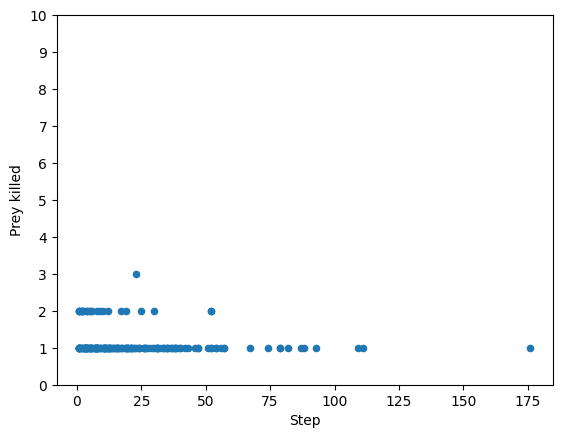

In [ ]:
from base import Agent, Action, Perception
from representation import GridRelativeOrientation, GridOrientation, GridPosition
from communication import SocialAction, AgentMessage
from hunting import HuntingEnvironment, WildLifeAgentData, WildLifeAgent
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt

import time, random

class ProbabilityMap(object):

    def __init__(self, existing_map = None):
        self.__internal_dict = {}

        if existing_map:
            for k, v in existing_map.list_actions():
                self.__internal_dict[k] = v

    def empty(self):
        if self.__internal_dict:
            return False

        return True


    def put(self, action, value):
        self.__internal_dict[action] = value

    def remove(self, action):
        """
        Updates a discrete action probability map by uniformly redistributing the probability of an action to remove over
        the remaining possible actions in the map.
        :param action: The action to remove from the map
        :return:
        """
        if action in self.__internal_dict:
            val = self.__internal_dict[action]
            del self.__internal_dict[action]

            remaining_actions = list(self.__internal_dict.keys())
            nr_remaining_actions = len(remaining_actions)

            if nr_remaining_actions != 0:
                prob_sum = 0
                for i in range(nr_remaining_actions - 1):
                    new_action_prob = (self.__internal_dict[remaining_actions[i]] + val) / float(nr_remaining_actions)
                    prob_sum += new_action_prob

                    self.__internal_dict[remaining_actions[i]] = new_action_prob

                self.__internal_dict[remaining_actions[nr_remaining_actions - 1]] = 1 - prob_sum


    def choice(self):
        """
        Return a random action from a discrete distribution over a set of possible actions.
        :return: an action chosen from the set of choices
        """
        r = random.random()
        count_prob = 0

        for a in self.__internal_dict.keys():
            count_prob += self.__internal_dict[a]
            if count_prob >= r:
                return a

        raise RuntimeError("Should never get to this point when selecting an action")

    def list_actions(self):
        return self.__internal_dict.items()


class MyAction(Action, Enum):
    """
    Physical actions for wildlife agents.
    """

    # The agent must move north (up)
    NORTH = 0

    # The agent must move east (right).
    EAST = 1

    # The agent must move south (down).
    SOUTH = 2

    # The agent must move west (left).
    WEST = 3



class MyAgentPerception(Perception):
    """
    The perceptions of a wildlife agent.
    """

    def __init__(self, agent_position, obstacles, nearby_predators, nearby_prey, messages = None):
        """
        Default constructor
        :param agent_position: agents's position.
        :param obstacles: visible obstacles
        :param nearby_predators: visible predators - given as tuple (agent_id, grid position)
        :param nearby_prey: visible prey - given as tuple (agent_id, grid_position)
        :param messages: incoming messages, may be None
        """
        self.agent_position = agent_position
        self.obstacles = obstacles
        self.nearby_predators = nearby_predators
        self.nearby_prey = nearby_prey

        if messages:
            self.messages = messages
        else:
            self.messages = []


class MyPrey(WildLifeAgent):
    """
    Implementation of the prey agent.
    """
    UP_PROB = 0.25
    LEFT_PROB = 0.25
    RIGHT_PROB = 0.25
    DOWN_PROB = 0.25

    def __init__(self):
        super(MyPrey, self).__init__(WildLifeAgentData.PREY)


    def response(self, perceptions):
        """
        :param perceptions: The perceptions of the agent at each step
        :return: The `Action' that your agent takes after perceiving the environment at each step
        """
        agent_pos = perceptions.agent_position
        probability_map = ProbabilityMap()
        probability_map.put(MyAction.NORTH,  MyPrey.UP_PROB)
        probability_map.put(MyAction.SOUTH, MyPrey.DOWN_PROB)
        probability_map.put(MyAction.WEST, MyPrey.LEFT_PROB)
        probability_map.put(MyAction.EAST, MyPrey.RIGHT_PROB)

        for obstacle_pos in perceptions.obstacles:
            if agent_pos.get_distance_to(obstacle_pos) > 1:
                continue

            relative_orientation = agent_pos.get_simple_relative_orientation(obstacle_pos)
            if relative_orientation == GridRelativeOrientation.FRONT:
                probability_map.remove(MyAction.NORTH)

            elif relative_orientation == GridRelativeOrientation.BACK:
                probability_map.remove(MyAction.SOUTH)

            elif relative_orientation == GridRelativeOrientation.RIGHT:
                probability_map.remove(MyAction.EAST)

            elif relative_orientation == GridRelativeOrientation.LEFT:
                probability_map.remove(MyAction.WEST)

        ## save available moves
        available_moves = ProbabilityMap(existing_map=probability_map)

        ## examine actions which are unavailable because of predators
        for (_, predator_pos) in perceptions.nearby_predators:
            relative_pos = agent_pos.get_simple_relative_orientation(predator_pos)

            if relative_pos == GridRelativeOrientation.FRONT:
                probability_map.remove(MyAction.NORTH)

            elif relative_pos == GridRelativeOrientation.FRONT_LEFT:
                probability_map.remove(MyAction.NORTH)
                probability_map.remove(MyAction.WEST)

            elif relative_pos == GridRelativeOrientation.FRONT_RIGHT:
                probability_map.remove(MyAction.NORTH)
                probability_map.remove(MyAction.EAST)

            elif relative_pos == GridRelativeOrientation.LEFT:
                probability_map.remove(MyAction.WEST)

            elif relative_pos == GridRelativeOrientation.RIGHT:
                probability_map.remove(MyAction.EAST)

            elif relative_pos == GridRelativeOrientation.BACK:
                probability_map.remove(MyAction.SOUTH)

            elif relative_pos == GridRelativeOrientation.BACK_LEFT:
                probability_map.remove(MyAction.SOUTH)
                probability_map.remove(MyAction.WEST)

            elif relative_pos == GridRelativeOrientation.BACK_RIGHT:
                probability_map.remove(MyAction.SOUTH)
                probability_map.remove(MyAction.EAST)

        if not probability_map.empty():
            return probability_map.choice()
        else:
            return available_moves.choice()



class MyPredator(WildLifeAgent):

    def __init__(self, map_width=None, map_height=None):
        super(MyPredator, self).__init__(WildLifeAgentData.PREDATOR)
        self.map_width = map_width
        self.map_height = map_height

    def response(self, perceptions: MyAgentPerception) -> MyAction:
        """
        TODO your response function for the predator agent with NO communication
        :param perceptions:
        :return:
        """
        agent_pos = perceptions.agent_position
        probability_map = ProbabilityMap()
        probability_map.put(MyAction.NORTH,  MyPrey.UP_PROB)
        probability_map.put(MyAction.SOUTH, MyPrey.DOWN_PROB)
        probability_map.put(MyAction.WEST, MyPrey.LEFT_PROB)
        probability_map.put(MyAction.EAST, MyPrey.RIGHT_PROB)

        for obstacle_pos in perceptions.obstacles:
            if agent_pos.get_distance_to(obstacle_pos) > 1:
                continue

            relative_orientation = agent_pos.get_simple_relative_orientation(obstacle_pos)
            if relative_orientation == GridRelativeOrientation.FRONT:
                probability_map.remove(MyAction.NORTH)

            elif relative_orientation == GridRelativeOrientation.BACK:
                probability_map.remove(MyAction.SOUTH)

            elif relative_orientation == GridRelativeOrientation.RIGHT:
                probability_map.remove(MyAction.EAST)

            elif relative_orientation == GridRelativeOrientation.LEFT:
                probability_map.remove(MyAction.WEST)

        ## save available moves
        available_moves = ProbabilityMap(existing_map=probability_map)

        ## examine actions which should be followed to catch the prey
        ## this means that if the prey is in one of the 8 directions, the predator should remove the opposite direction
        for (_, prey_pos) in perceptions.nearby_prey:
            relative_pos = agent_pos.get_simple_relative_orientation(prey_pos)

            if relative_pos == GridRelativeOrientation.FRONT:
                probability_map.remove(MyAction.SOUTH)

            elif relative_pos == GridRelativeOrientation.FRONT_LEFT:
                probability_map.remove(MyAction.SOUTH)
                probability_map.remove(MyAction.EAST)

            elif relative_pos == GridRelativeOrientation.FRONT_RIGHT:
                probability_map.remove(MyAction.SOUTH)
                probability_map.remove(MyAction.WEST)

            elif relative_pos == GridRelativeOrientation.LEFT:
                probability_map.remove(MyAction.EAST)

            elif relative_pos == GridRelativeOrientation.RIGHT:
                probability_map.remove(MyAction.WEST)

            elif relative_pos == GridRelativeOrientation.BACK:
                probability_map.remove(MyAction.NORTH)

            elif relative_pos == GridRelativeOrientation.BACK_LEFT:
                probability_map.remove(MyAction.NORTH)
                probability_map.remove(MyAction.EAST)

            elif relative_pos == GridRelativeOrientation.BACK_RIGHT:
                probability_map.remove(MyAction.NORTH)
                probability_map.remove(MyAction.WEST)

        if not probability_map.empty():
            return probability_map.choice()
        else:
            return available_moves.choice()

class MyPredatorWithCommunication(MyPredator):
    def __init__(self, map_width=None, map_height=None):
        super(MyPredatorWithCommunication, self).__init__(map_width, map_height)
        self.known_predators = set()
        self.target_prey = None
        self.spiral_moves = [MyAction.NORTH, MyAction.EAST, MyAction.SOUTH, MyAction.WEST]  # Spiral search pattern
        self.spiral_index = 0
        self.steps_in_direction = 1
        self.step_count = 0

    def response(self, perceptions: MyAgentPerception) -> SocialAction:
        action = None

        # Memorize nearby predators for communication
        for predator_id, predator_pos in perceptions.nearby_predators:
            if predator_id != self.id and predator_id not in self.known_predators:
                if perceptions.agent_position.get_distance_to(predator_pos) <= 3:
                    self.known_predators.add(predator_id)
                    print(f"Predator {self.id} memorized Predator {predator_id}")

        # Check for visible prey
        closest_prey = None
        min_distance = float('inf')

        for prey_id, prey_pos in perceptions.nearby_prey:
            distance = perceptions.agent_position.get_distance_to(prey_pos)
            if distance < min_distance:
                min_distance = distance
                closest_prey = prey_pos

        # If prey is visible, set it as target and notify other predators
        messages = []
        if closest_prey:
            self.target_prey = closest_prey
            print(f"Predator {self.id} found prey at {closest_prey}")
            for known_predator in self.known_predators:
                messages.append(AgentMessage(self.id, known_predator, f"Found prey at {closest_prey}"))
        else:
            # If no prey is visible, check incoming messages
            for message in perceptions.messages:
                if "Found prey" in message.content:
                    reported_prey_pos = eval(message.content.split("at ")[1])
                    if isinstance(reported_prey_pos, tuple):
                        reported_prey_pos = GridPosition(reported_prey_pos[0], reported_prey_pos[1])
                    reported_distance = perceptions.agent_position.get_distance_to(reported_prey_pos)
                    if not self.target_prey or reported_distance < perceptions.agent_position.get_distance_to(self.target_prey):
                        self.target_prey = reported_prey_pos
                        print(f"Predator {self.id} changed target to prey at {reported_prey_pos} based on message")

        # If we have a prey target, move towards it
        if self.target_prey:
            relative_pos = perceptions.agent_position.get_simple_relative_orientation(self.target_prey)

            if relative_pos == GridRelativeOrientation.FRONT:
                action = MyAction.NORTH
            elif relative_pos == GridRelativeOrientation.FRONT_LEFT:
                action = random.choice([MyAction.NORTH, MyAction.WEST])
            elif relative_pos == GridRelativeOrientation.FRONT_RIGHT:
                action = random.choice([MyAction.NORTH, MyAction.EAST])
            elif relative_pos == GridRelativeOrientation.LEFT:
                action = MyAction.WEST
            elif relative_pos == GridRelativeOrientation.RIGHT:
                action = MyAction.EAST
            elif relative_pos == GridRelativeOrientation.BACK:
                action = MyAction.SOUTH
            elif relative_pos == GridRelativeOrientation.BACK_LEFT:
                action = random.choice([MyAction.SOUTH, MyAction.WEST])
            elif relative_pos == GridRelativeOrientation.BACK_RIGHT:
                action = random.choice([MyAction.SOUTH, MyAction.EAST])
            print(f"Predator {self.id} moving {action} towards prey at {self.target_prey}")

        # If no target, follow the **spiral search pattern**
        if not action:
            action = self.spiral_moves[self.spiral_index]
            self.step_count += 1

            # Change direction after `steps_in_direction` moves
            if self.step_count >= self.steps_in_direction:
                self.spiral_index = (self.spiral_index + 1) % 4
                self.step_count = 0
                if self.spiral_index % 2 == 0:
                    self.steps_in_direction += 1

            print(f"Predator {self.id} following spiral search pattern: {action}")

        # Create SocialAction and add messages
        social_action = SocialAction(action)
        for msg in messages:
            print(f"Predator {self.id} sending message to {msg.destination_id}: {msg.content}")
            social_action.add_outgoing_message(msg.sender_id, msg.destination_id, msg.content)

        return social_action

class MyEnvironment(HuntingEnvironment):
    """
    Your implementation of the environment in which cleaner agents work.
    """
    PREY_RANGE = 2
    PREDATOR_RANGE = 3

    def __init__(self, predator_agent_type, w, h, num_predators, num_prey, rand_seed = 42, prey_kill_times = None):
        """
        Default constructor. This should call the initialize methods offered by the super class.
        """
        if not prey_kill_times:
            self.prey_kill_times = []
        else:
            self.prey_kill_times = prey_kill_times
        self.step_count = 0

        print("Seed = %i" % rand_seed)
        super(MyEnvironment, self).__init__()

        predators = []
        prey = []

        for i in range(num_predators):
            predators.append(predator_agent_type(map_width=w, map_height=h))

        for i in range(num_prey):
            prey.append(MyPrey())

        """ Message box for messages that need to be delivered by the environment to their respective recepients, on
        the next turn """
        self.message_box = []

        ## initialize the huniting environment
        self.initialize(w=w, h=h, predator_agents=predators, prey_agents=prey, rand_seed = rand_seed)


    def step(self):
        """
        This method should iterate through all agents, provide them provide them with perceptions, and apply the
        action they return.
        """
        """
        STAGE 1: generate perceptions for all agents, based on the state of the environment at the beginning of this
        turn
        """
        agent_perceptions = {}

        ## get perceptions for prey agents
        for prey_data in self._prey_agents:
            nearby_obstacles = self.get_nearby_obstacles(prey_data.grid_position, MyEnvironment.PREY_RANGE)
            nearby_predators = self.get_nearby_predators(prey_data.grid_position, MyEnvironment.PREY_RANGE)
            nearby_prey = self.get_nearby_prey(prey_data.grid_position, MyEnvironment.PREY_RANGE)

            predators = [(ag_data.linked_agent.id, ag_data.grid_position) for ag_data in nearby_predators]
            prey = [(ag_data.linked_agent.id, ag_data.grid_position) for ag_data in nearby_prey]

            agent_perceptions[prey_data] = MyAgentPerception(agent_position=prey_data.grid_position,
                                                             obstacles=nearby_obstacles,
                                                             nearby_predators=predators,
                                                             nearby_prey=prey)

        ## TODO: create perceptions for predator agents, including messages in the `message_box`
        for predator_data in self._predator_agents:
            nearby_obstacles = self.get_nearby_obstacles(predator_data.grid_position, MyEnvironment.PREDATOR_RANGE)
            nearby_predators = self.get_nearby_predators(predator_data.grid_position, MyEnvironment.PREDATOR_RANGE)
            nearby_prey = self.get_nearby_prey(predator_data.grid_position, MyEnvironment.PREDATOR_RANGE)

            predators = [(ag_data.linked_agent.id, ag_data.grid_position) for ag_data in nearby_predators]
            prey = [(ag_data.linked_agent.id, ag_data.grid_position) for ag_data in nearby_prey]

            messages = AgentMessage.filter_messages_for(self.message_box, predator_data.linked_agent)

            agent_perceptions[predator_data] = MyAgentPerception(agent_position=predator_data.grid_position,
                                                                 obstacles=nearby_obstacles,
                                                                 nearby_predators=predators,
                                                                 nearby_prey=prey,
                                                                 messages=messages)

        """
        STAGE 2: call response for each agent to obtain desired actions
        """
        agent_actions = {}
        new_messages = []
        ## TODO: get actions for all agents
        for prey_data in self._prey_agents:
            agent_actions[prey_data] = prey_data.linked_agent.response(agent_perceptions[prey_data])

        for predator_data in self._predator_agents:
            response = predator_data.linked_agent.response(agent_perceptions[predator_data])

            if isinstance(response, SocialAction):
                agent_actions[predator_data] = response.action
                new_messages.extend(response.outgoing_messages)
            else:
                agent_actions[predator_data] = response

        """
        STAGE 3: apply the agents' actions in the environment
        """
        for prey_data in self._prey_agents:
            if not prey_data in agent_actions:
                print("Agent %s did not opt for any action!" % str(prey_data))

            else:
                prey_action = agent_actions[prey_data]
                new_position = None

                if prey_action == MyAction.NORTH:
                    new_position = prey_data.grid_position.get_neighbour_position(GridOrientation.NORTH)
                elif prey_action == MyAction.SOUTH:
                    new_position = prey_data.grid_position.get_neighbour_position(GridOrientation.SOUTH)
                elif prey_action == MyAction.EAST:
                    new_position = prey_data.grid_position.get_neighbour_position(GridOrientation.EAST)
                elif prey_action == MyAction.WEST:
                    new_position = prey_data.grid_position.get_neighbour_position(GridOrientation.WEST)

                if not new_position in self._xtiles:
                    prey_data.grid_position = new_position
                else:
                    print("Agent %s tried to go through a wall!" % str(prey_data))

        for predator_data in self._predator_agents:
            if not predator_data in agent_actions:
                print("Agent %s did not opt for any action!" % str(predator_data))

            else:
                predator_action = agent_actions[predator_data]
                new_position = None
                ## TODO: handle case for a SocialAction instance

                if predator_action == MyAction.NORTH:
                    new_position = predator_data.grid_position.get_neighbour_position(GridOrientation.NORTH)
                elif predator_action == MyAction.SOUTH:
                    new_position = predator_data.grid_position.get_neighbour_position(GridOrientation.SOUTH)
                elif predator_action == MyAction.EAST:
                    new_position = predator_data.grid_position.get_neighbour_position(GridOrientation.EAST)
                elif predator_action == MyAction.WEST:
                    new_position = predator_data.grid_position.get_neighbour_position(GridOrientation.WEST)

                if not new_position in self._xtiles:
                    predator_data.grid_position = new_position
                else:
                    print("Agent %s tried to go through a wall!" % str(predator_data))


        # increment the step count
        self.step_count += 1

        """
        At the end of the turn remove the dead prey. If any prey was killed, add a tuple containing the
        current step count and the number of prey killed at this step to the list of prey kill times.
        """
        num_prey_killed = self.remove_dead_prey()
        if num_prey_killed > 0:
            self.prey_kill_times.append((self.step_count, num_prey_killed))

        self.message_box = new_messages

    def get_step_count(self):
        """
        :return: the number of steps that have been executed in the environment
        """
        return self.step_count

    def get_prey_kill_times(self):
        """
        :return: a list of tuples containing the step count and the number of prey killed at that step
        """
        return self.prey_kill_times


class Tester(object):

    def __init__(self, predator_agent_type = MyPredator, num_predators=4, num_prey=10, width=15, height=10, rand_seed = 42, delay=0.1):
        self.num_predators = num_predators
        self.num_prey = num_prey
        self.width = width
        self.height = height
        self.delay = delay

        # reset the agent counter for generating unique agent ids
        WildLifeAgent.agent_counter = 0

        self.env = MyEnvironment(predator_agent_type, self.width, self.height, self.num_predators, self.num_prey, rand_seed=rand_seed)
        self.make_steps()

    def make_steps(self):
        while not self.env.goals_completed():
            self.env.step()

            print(self.env)

            time.sleep(self.delay)

        # return the number of steps and the prey kill times
        return self.env.get_step_count(), self.env.get_prey_kill_times()


if __name__ == "__main__":
    tester = Tester(predator_agent_type=MyPredatorWithCommunication, rand_seed=42, delay=0.1)
    step_count, prey_kill_times = tester.make_steps()
    print("Step count: ", step_count)
    print("Prey kill times: ", prey_kill_times)

    NUM_TESTS = 20

    step_count_list = []
    prey_kill_times_list = []

    for i in range(NUM_TESTS):
        tester = Tester(predator_agent_type=MyPredator, rand_seed=42+i, delay=0.1)
        step_count, prey_kill_times = tester.make_steps()

        step_count_list.append(step_count)
        prey_kill_times_list.append(prey_kill_times)

    # Make an analysis of the min, max, median step counts and standard deviation as a describe call
    print("Step count analysis")
    print(pd.Series(step_count_list).describe())

    # Make an analysis of the most common kill times as a scatter plot
    print("Prey kill times analysis")
    prey_kill_times = [item for sublist in prey_kill_times_list for item in sublist]
    df = pd.DataFrame(prey_kill_times, columns=["Step", "Prey killed"])
    df.plot(kind="scatter", x="Step", y="Prey killed", xlabel="Step", ylabel="Prey killed", yticks=range(0, 11, 1))
    plt.show()

# **representation.py**

In [ ]:
%%writefile representation.py
from enum import Enum
import math

class GridRelativeOrientation(Enum):
    """
    Implementation for orthogonal and diagonal relative orientations in a rectangular grid.
    """
    FRONT = 0
    FRONT_RIGHT = 1
    RIGHT = 2
    BACK_RIGHT = 3
    BACK = 4
    BACK_LEFT = 5
    LEFT = 6
    FRONT_LEFT = 7

class GridOrientation(Enum):
    NORTH = (0, 0, 1, "^")
    EAST = (1, 1, 0, ">")
    SOUTH = (2, 0, -1, "v")
    WEST = (3, -1, 0, "<")

    def __init__(self, ordinal, dx, dy, display_string):
        self.ordinal = ordinal
        self.dx = dx
        self.dy = dy
        self.display_string = display_string

    def __str__(self):
        return self.display_string

    # NORTH = Orientation(1, 0, 1,    "^")
    # EAST = Orientation(2, 1, 0,     ">")
    # SOUTH = Orientation(3, 0, -1,   "v")
    # WEST = Orientation(4, -1, 0,    "<")


    def compute_relative_orientation(self, relative_orientation):
        """
        Computes the absolute orientation that is at the specified orientation relative to `this'.
        E.g. if the current orientation is SOUTH and the relative orientation is RIGHT, the result is WEST.
        :param relative_orientation: the GridRelativeOrientation value
        :return: the resulting GridOrientation instance
        """
        angle = relative_orientation.value
        is_half_angle = (angle % 2) != 0
        if is_half_angle:
            raise ValueError("the relative orientation must be a straight angle")

        straight_angle = angle // 2
        return list(GridOrientation)[(self.ordinal + straight_angle) % 4]

    def get_relative_dx(self, relative):
        """
        Returns the delta x for the position at the indicated orientation, relative to <code>this</code> orientation.
        E.g. if the orientation is EAST, and the relative orientation is BACK-RIGHT, the resulting orientation is
        SOUTH-WEST, with a delta x of -1 and a delta y of -1.
        :param relative: the relative orientation
        :return: the delta x of the position at that relative orientation.
        """
        angle = relative.value
        straight_angle = angle // 2
        is_half_angle = angle % 2

        straight_result = (self.ordinal + straight_angle) % 4

        res = list(GridOrientation)[straight_result].dx
        if is_half_angle:
            res += list(GridOrientation)[(straight_result + 1) % 4].dx

        return res


    def get_relative_dy(self, relative):
        """
        Returns the delta y for the position at the indicated orientation, relative to <code>this</code> orientation.
        E.g. if the orientation is EAST, and the relative orientation is BACK-RIGHT, the resulting orientation is
        SOUTH-WEST, with a delta x of -1 and a delta y of -1.
        :param relative: the relative orientation
        :return: the delta y of the position at that relative orientation.
        """
        angle = relative.value
        straight_angle = angle // 2
        is_half_angle = angle % 2

        straight_result = (self.ordinal + straight_angle) % 4

        res = list(GridOrientation)[straight_result].dy
        if is_half_angle:
            res += list(GridOrientation)[(straight_result + 1) % 4].dy

        return res


class GridPosition(object):
    """
    Implementation for positions in a rectangular grid.
    """
    def __init__(self, x, y):
        self.__x = x
        self.__y = y

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.__x == other.__x and self.__y == other.__y
        else:
            return False

    def __hash__(self):
        return self.__x + self.__y

    def __str__(self):
        return "(%i, %i)" % (self.__x, self.__y)


    # def get_neighbour_position(self, direction):
    #     """
    #     Returns the position that is one of the 4 orthogonal neighbors of <code>this</code> and is in a direction
    #     indicated by the orientation argument.
    #     E.g. if direction is NORTH, the returned position will be north of this.
    #     :param direction: direction of the neighbor position, as an `GridOrientation' instance.
    #     :return: the neighbour `GridPosition'
    #     """
    #     if direction == GridOrientation.NORTH:
    #         return GridPosition(self.__x, self.__y + 1)
    #     elif direction == GridOrientation.EAST:
    #         return GridPosition(self.__x + 1, self.__y)
    #     elif direction == GridOrientation.SOUTH:
    #         return GridPosition(self.__x, self.__y - 1)
    #     elif direction == GridOrientation.WEST:
    #         return GridPosition(self.__x - 1, self.__y)
    #
    #     return None


    def get_neighbour_position(self, direction, relative_orientation = GridRelativeOrientation.FRONT):
        """
        Returns the position that is one of the 8 (orthogonal and diagonal) neighbors of <code>this</code> and is in a
        direction that has the provided orientation relative to the provided direction.
        :param direction: direction used to compute the neighbor position, as an `GridOrientation' instance.
        :param relative_orientation: orientation of the returned position, relative to the direction
        in the first argument. The default relative orientation is FRONT, which means the function will compute the
        neighbour cell that is in the "direction" specified by :arg direction.
        E.g. if direction is NORTH, the returned position will be north of this, relative to the grid.
        If it is WEST, the returned position will be west of this, relative to the grid.
        :return: the neighbor `GridPosition'
        """
        return GridPosition(self.__x + direction.get_relative_dx(relative_orientation),
                            self.__y + direction.get_relative_dy(relative_orientation))


    def is_neighbour(self, grid_position):
        """
        Indicates whether the provided position is a neighbor (orthogonal or diagonal).
        :param grid_position: the candidate `GridPosition' neighbour
        :return: True if the candidate is a neighbour
        """
        return abs(self.__x - grid_position.__x) <= 1 and abs(self.__y - grid_position.__y) <= 1


    def is_neighbour_ortho(self, grid_position):
        """
        Indicates whether the provided position is an orthogonal neighbor (north, south, east or west).
        :param grid_position: the candidate neighbor.
        :return: True if the candidate is a neighbour
        """
        return (abs(self.__x - grid_position.__x) == 1 and self.__y == grid_position.__y) or \
               (self.__x == grid_position.__x and abs(self.__y - grid_position.__y) == 1)


    def get_simple_relative_orientation(self, other_position):
        """
        Determines the relative orientation of another GridPosition with respect to `this'.
        :param other_position: The position for which the relative orientation needs to be determined.
        :return: The `GridRelativeOrientation' of `otherPosition' with respect to the current one.
        """
        delta_x = other_position.__x - self.__x
        if delta_x < 0:
            delta_x = -1
        elif delta_x > 0:
            delta_x = 1

        delta_y = other_position.__y - self.__y
        if delta_y < 0:
            delta_y = -1
        elif delta_y > 0:
            delta_y = 1

        if delta_x == 0:
            if delta_y >= 0:
                return GridRelativeOrientation.FRONT
            return GridRelativeOrientation.BACK
        elif delta_x > 0:
            if delta_y > 0:
                return  GridRelativeOrientation.FRONT_RIGHT
            elif delta_y < 0:
                return GridRelativeOrientation.BACK_RIGHT
            else:
                return GridRelativeOrientation.RIGHT
        else:
            if delta_y > 0:
                return GridRelativeOrientation.FRONT_LEFT
            elif delta_y < 0:
                return GridRelativeOrientation.BACK_LEFT
            else:
                return GridRelativeOrientation.LEFT


    def get_relative_orientation(self, reference_orientation, neighbour_position):
        """
        Returns the relative orientation of a position relative to `this' position and a reference
        orientation.
        E.g. for a `GridOrientation' reference_orientation of EAST, an orthogonal `GridPosition' neighbor position to
        the right of this position will be in FRONT.
        :param reference_orientation: the absolute orientation which is considered as 'front', or 'forward'.
        :param neighbour_position: the position for which to compute the relative orientation.
        :return: the relative orientation.
        """
        if not self.is_neighbour(neighbour_position):
            raise ValueError("Given position is not a neighbor")

        for orientation in list(GridRelativeOrientation):
            if self.get_neighbour_position(reference_orientation, orientation) == neighbour_position:
                return orientation

        raise RuntimeError("Should not be here!")


    def get_distance_to(self, grid_position):
        """
        Computes the Manhatten distance from a specified position
        :param grid_position: the other `GridPosition' position
        :return: the distance
        """
        return abs(self.__x - grid_position.__x) + abs(self.__y - grid_position.__y)


    def is_x_even(self):
        """
        :return: True if the x coordinate is even
        """
        return abs(self.__x) % 2 == 0

    def is_y_event(self):
        """
        :return: True if the y coordinate is even
        """
        return abs(self.__y) % 2 == 0


if __name__ == "__main__":
    pos = GridPosition(1, 1)

    print(pos.get_neighbour_position(GridOrientation.NORTH))
    print(pos.get_neighbour_position(GridOrientation.EAST))
    print(pos.get_neighbour_position(GridOrientation.WEST))
    print(pos.get_neighbour_position(GridOrientation.SOUTH))

    print("===========")
    print(pos.get_neighbour_position(GridOrientation.SOUTH, GridRelativeOrientation.FRONT))
    print(pos.get_neighbour_position(GridOrientation.SOUTH, GridRelativeOrientation.FRONT_LEFT))
    print(pos.get_neighbour_position(GridOrientation.SOUTH, GridRelativeOrientation.FRONT_RIGHT))
    print(pos.get_neighbour_position(GridOrientation.SOUTH, GridRelativeOrientation.BACK))
    print(pos.get_neighbour_position(GridOrientation.SOUTH, GridRelativeOrientation.BACK_LEFT))
    print(pos.get_neighbour_position(GridOrientation.SOUTH, GridRelativeOrientation.BACK_RIGHT))



# **RUN**

In [ ]:
! python my_world.py

Seed = 42
  | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|11|12|13|14|15|16|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
11|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|
  |XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
10|XX|F9|  |  |F8|  |  |  |  |  |F1|  |  |  |  |  |XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 9|XX|  |F1|  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 8|XX|  |  |  |  |  |  |  |  |  |  |F1|  |  |  |  |XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 7|XX|  |  |  |  |  |  |  |  |  |  |F4|  |  |  |  |XX|
  |XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
 6|XX|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |XX|
